In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.Bhushan_utils import *

In [2]:
# Train data read
df = pd.read_csv("D:\\MComp\\KDDM\\Project\\cs5228_project\\dataset\\train.csv")
print(len(df))

25000


# Feature Analysis

In [18]:
# df copy for EDA
df_trial = df.copy()

# Correlation matrix block
corr_matrix = df['price'].corr(df['depreciation'])
print(corr_matrix)

0.8118056032938004


In [3]:
# Block to check missing value
missing = df['depreciation'].isnull().sum()
print(missing)

507


In [4]:
# Make model Imputation
unique_makes = df_trial['make'].unique()
unique_makes_list = sorted([make for make in unique_makes if pd.notnull(make)])
makes_regex = compile_make_pattern(unique_makes_list)
df_trial = apply_make_extraction(df_trial, makes_regex)

In [5]:
# Car age
df_trial = calc_vehicle_age(df_trial)

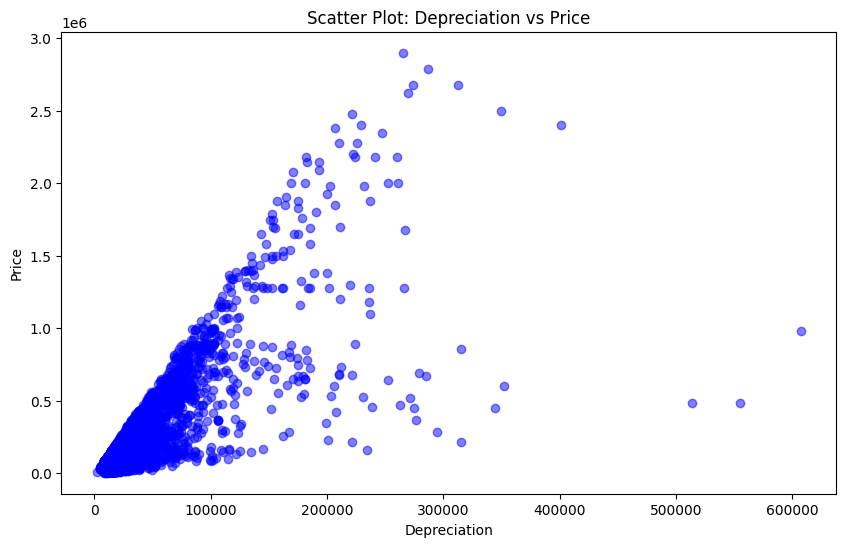

depreciation        1.000000
arf                 0.823259
price               0.811806
omv                 0.776646
dereg_value         0.706500
power               0.674149
road_tax            0.511066
engine_cap          0.451648
coe                 0.205189
curb_weight         0.160003
manufactured        0.062598
no_of_owners        0.013676
car_age            -0.062598
listing_id         -0.139441
mileage            -0.251363
indicative_price         NaN
Name: depreciation, dtype: float64


In [28]:
# Depreciation Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df_trial['depreciation'], df_trial['price'], color='blue', alpha=0.5)
plt.title('Scatter Plot: Depreciation vs Price')
plt.xlabel('Depreciation')
plt.ylabel('Price')
plt.show()

#Depreciation correlation
numerical_df = df_trial.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
depreciation_corr = correlation_matrix['depreciation']
depreciation_corr_sorted = depreciation_corr.sort_values(ascending=False)
print(depreciation_corr_sorted)

In [6]:
# Depreciation Imputation

# Using make-model-age
df_depreciation_mma = df_trial.copy()
avg_depreciation_rate_with_age = calculate_depreciation_rate_with_age(df_depreciation_mma)
for i, row in df_depreciation_mma.iterrows():
        # If depreciation is missing
        if pd.isnull(row['depreciation']):
            make_model_age = (row['extracted_make'], row['model'], row['car_age'])

            # Null records with matching make-model-age group
            if make_model_age in avg_depreciation_rate_with_age:
                df_depreciation_mma.at[i, 'depreciation'] = avg_depreciation_rate_with_age[make_model_age]

# Using make-model
df_depreciation_mm = df_trial.copy()
avg_depreciation_rate_without_age = calculate_depreciation_rate_without_age(df_depreciation_mm)
for i, row in df_depreciation_mm.iterrows():
        # If depreciation is missing
        if pd.isnull(row['depreciation']):
            make_model = (row['extracted_make'], row['model'])

            # Null records with matching make-model-age group
            if make_model in avg_depreciation_rate_without_age:
                df_depreciation_mm.at[i, 'depreciation'] = avg_depreciation_rate_without_age[make_model]

# Using mean of all records
df_depreciation_mean = df_trial.copy()
mean_value = df_depreciation_mean['depreciation'].mean()
df_depreciation_mean['depreciation'] = df_depreciation_mean['depreciation'].fillna(mean_value)

Before missing values:
507
After missing values make-model-age:
110
After missing values make-model:
13
After missing values mean:
0


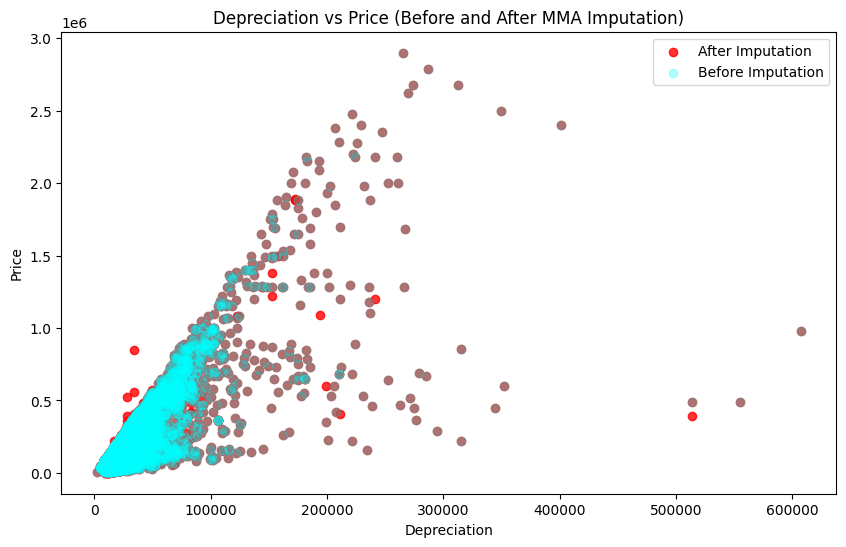

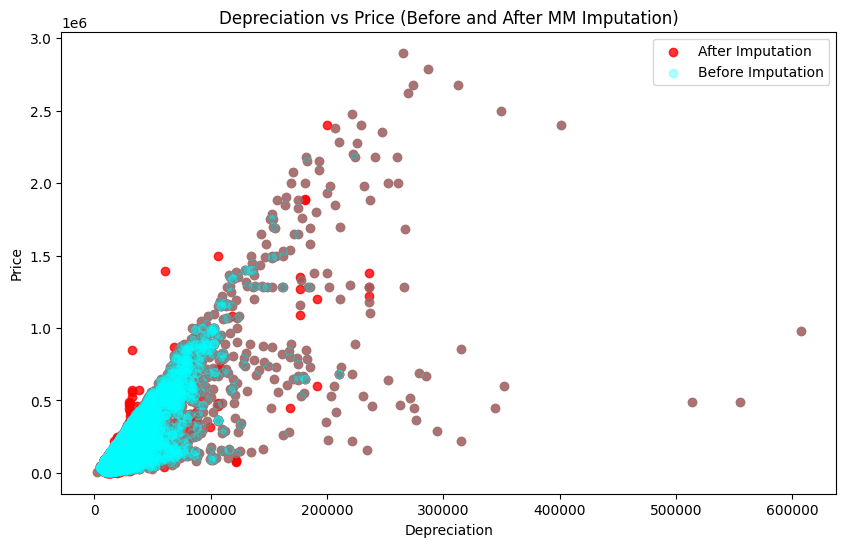

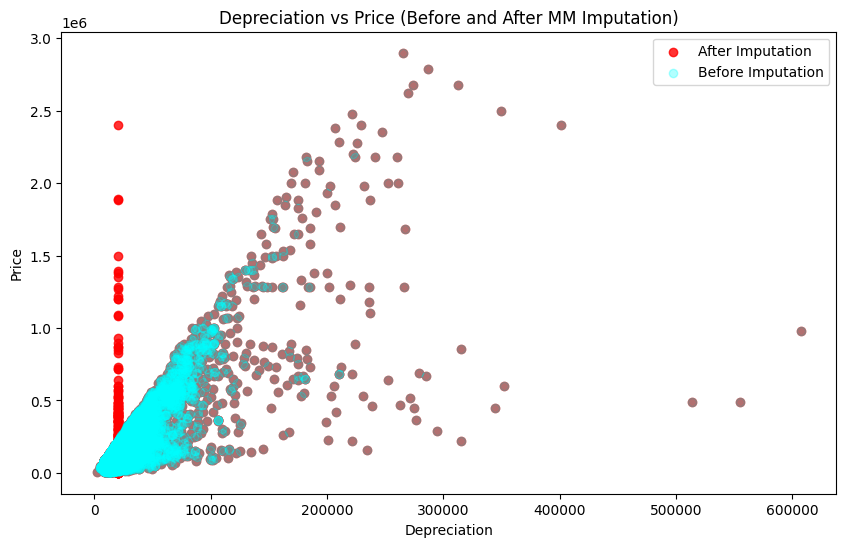

In [7]:
# Depreciation compare before and after imputation

print("Before missing values | After missing values make-model-age | After missing values make-model | After missing values mean")
print(df_trial['depreciation'].isnull().sum(), df_depreciation_mma['depreciation'].isnull().sum(), df_depreciation_mm['depreciation'].isnull().sum()), df_depreciation_mean['depreciation'].isnull().sum())

# Before vs after scatter plot for depreciation vs price (make-model-age)
plt.figure(figsize=(10, 6))
plt.scatter(df_depreciation_mma['depreciation'], df_depreciation_mma['price'], alpha=0.8, color='red', label='After Imputation')
plt.scatter(df['depreciation'], df['price'], alpha=0.3, color='cyan', label='Before Imputation')
plt.title('Depreciation vs Price (Before and After MMA Imputation)')
plt.ylabel('Price')
plt.xlabel('Depreciation')
plt.legend()
plt.show()

# Before vs after scatter plot for depreciation vs price (make-model)
plt.figure(figsize=(10, 6))
plt.scatter(df_depreciation_mm['depreciation'], df_depreciation_mm['price'], alpha=0.8, color='red', label='After Imputation')
plt.scatter(df['depreciation'], df['price'], alpha=0.3, color='cyan', label='Before Imputation')
plt.title('Depreciation vs Price (Before and After MM Imputation)')
plt.ylabel('Price')
plt.xlabel('Depreciation')
plt.legend()
plt.show()

# Before vs after scatter plot for depreciation vs price (mean)
plt.figure(figsize=(10, 6))
plt.scatter(df_depreciation_mean['depreciation'], df_depreciation_mean['price'], alpha=0.8, color='red', label='After Imputation')
plt.scatter(df['depreciation'], df['price'], alpha=0.3, color='cyan', label='Before Imputation')
plt.title('Depreciation vs Price (Before and After MM Imputation)')
plt.ylabel('Price')
plt.xlabel('Depreciation')
plt.legend()
plt.show()

# Calculate average depreciation for each make and model
#print("Avg depreciation for each make-model")
#average_depreciation_mma = df_depreciation_mma.groupby(['make', 'model'])['depreciation'].mean().reset_index()
#average_depreciation_mma.columns = ['make', 'model', 'average_depreciation']
#print(average_depreciation)

#print("Make-model groups with null depreciation")
#null_depreciation_rows = df_processed[df_processed['depreciation'].isnull()]
#print(null_depreciation_rows[['extracted_make', 'model']])

In [8]:
df_depriciation_calc = df_trial.copy()

df_depriciation_calc['expected_depreciation'] = (df_depriciation_calc['omv'] - df_depriciation_calc['price']) / df_depriciation_calc['car_age']

# Check if actual depreciation matches expected depreciation
df_depriciation_calc['depreciation_matches'] = df_depriciation_calc['depreciation'] == df_depriciation_calc['expected_depreciation']

# Count the number of records where depreciation matches
matching_records_count = df_depriciation_calc['depreciation_matches'].sum()

# Print the count of matching records
print(f"Number of records with matching depreciation: {matching_records_count}")

# Optional: Display records where depreciation does not match
non_matching_records = df_depriciation_calc[~df_depriciation_calc['depreciation_matches']]
print(non_matching_records[['extracted_make', 'model', 'depreciation', 'expected_depreciation']])

Number of records with matching depreciation: 0
      extracted_make     model  depreciation  expected_depreciation
0         land rover     range       34270.0          -17480.333333
1      mercedes-benz      c200       21170.0           -8017.428571
2              honda   odyssey       12520.0            -694.470588
3             toyota     altis       10140.0           -1794.750000
4              lexus        gs       13690.0            1367.444444
...              ...       ...           ...                    ...
24995  mercedes-benz      c180       12440.0           -4152.384615
24996        bentley  bentayga           NaN          -45958.666667
24997  mercedes-benz      a180       21290.0             -99.100000
24998           audi        a3       15010.0           -4218.285714
24999            bmw      220i       25120.0           -5685.125000

[25000 rows x 4 columns]


0
['auto' 'manual'] transmission
auto      23301
manual     1699
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

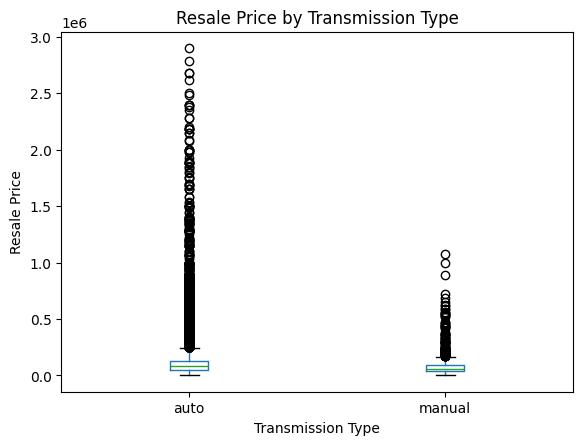

In [19]:
# Transmission

print(df_trial['transmission'].isnull().sum())

unique_transmissions = df_trial['transmission'].unique()
transmission_counts = df_trial['transmission'].value_counts()
print(unique_transmissions, transmission_counts)

# Box plot for resale price by transmission type
plt.figure(figsize=(10, 6))
df_trial.boxplot(column='price', by='transmission', grid=False)
plt.title('Resale Price by Transmission Type')
plt.suptitle('')  # Remove default title
plt.xlabel('Transmission Type')
plt.ylabel('Resale Price')
plt.show()

In [11]:
# Compare manufactured year and registration year

df_regdate_combine = df_trial.copy()
df_regdate_combine['effective_reg_date'] = df_regdate_combine['original_reg_date'].fillna(df_regdate_combine['reg_date'])
df_regdate_combine = df_regdate_combine.drop(columns=['original_reg_date', 'reg_date'])

df_regdate_combine['effective_reg_date'] = pd.to_datetime(df_regdate_combine['effective_reg_date'], errors='coerce', format='%d-%b-%Y')

df_regdate_combine['reg_year'] = df_regdate_combine['effective_reg_date'].dt.year

df_regdate_combine['is_year_match'] = df_regdate_combine['manufactured'] == df_regdate_combine['reg_year']
mismatch_count = df_regdate_combine['is_year_match'].value_counts()
print(mismatch_count)

# Filter rows where the years don't match
mismatched_records = df_regdate_combine[df_regdate_combine['is_year_match'] == False]

# Print the relevant columns for mismatched records
print(mismatched_records[['manufactured', 'effective_reg_date', 'reg_year']])

is_year_match
True     15238
False     9762
Name: count, dtype: int64
       manufactured effective_reg_date  reg_year
7            2009.0         2010-01-26      2010
9            2008.0         2009-03-05      2009
10           2010.0         2011-03-16      2011
14           2016.0         2017-01-11      2017
19           2018.0         2019-01-11      2019
...             ...                ...       ...
24983        2019.0         2020-07-14      2020
24987        2015.0         2016-02-24      2016
24991        2022.0         2023-12-22      2023
24992        2022.0         2023-02-24      2023
24997        2014.0         2015-04-01      2015

[9762 rows x 3 columns]


0


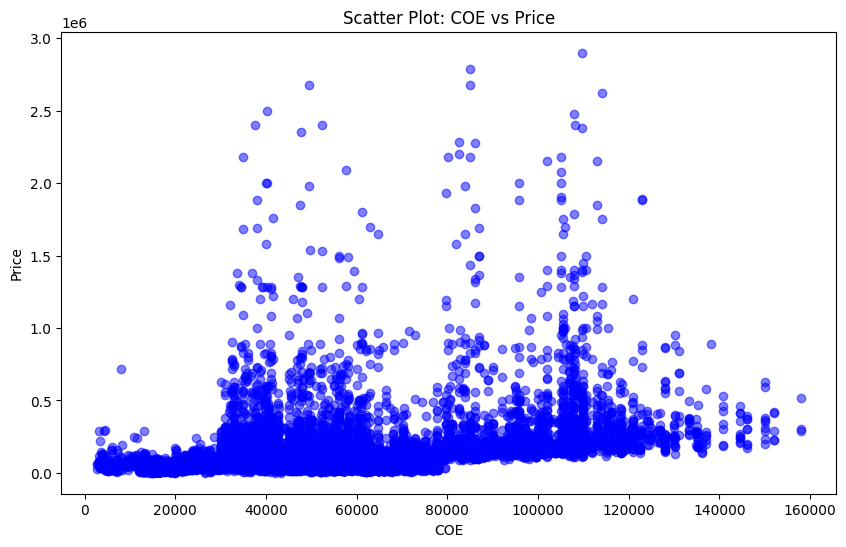

coe                 1.000000
dereg_value         0.477311
price               0.356526
manufactured        0.313562
power               0.298417
arf                 0.242024
omv                 0.235019
depreciation        0.205189
road_tax            0.175221
engine_cap          0.088011
curb_weight         0.045155
listing_id         -0.037059
no_of_owners       -0.175808
car_age            -0.313562
mileage            -0.341928
indicative_price         NaN
Name: coe, dtype: float64


In [26]:
#COE

#Null values
print(df_trial['coe'].isnull().sum())

# Scatter plot
plt.figure(figsize=(10,6))  # Optional, for adjusting the figure size
plt.scatter(df_trial['coe'], df_trial['price'], color='blue', alpha=0.5)
plt.title('Scatter Plot: COE vs Price')
plt.xlabel('COE')
plt.ylabel('Price')
plt.show()

# Correlation
numerical_df = df_trial.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
depreciation_corr = correlation_matrix['coe']
depreciation_corr_sorted = depreciation_corr.sort_values(ascending=False)
print(depreciation_corr_sorted)

# Final Pre-processing

In [3]:
df_processed = df.copy()
# Make model Imputation
unique_makes = df_processed['make'].unique()
unique_makes_list = sorted([make for make in unique_makes if pd.notnull(make)])
makes_regex = compile_make_pattern(unique_makes_list)
df_processed = apply_make_extraction(df_processed, makes_regex)

# Cylinders
df_processed['cylinder_cnt'] = df_processed['features'].apply(lambda x: extract_cylinder_from_features(x) if pd.notnull(x) else None)
cylinder_count_by_make_model = extract_cylinder_by_model_make(df_processed)

In [4]:
# Manufactured

df_processed['effective_reg_date'] = df_processed['original_reg_date'].fillna(df_processed['reg_date'])
df_processed = df_processed.drop(columns=['original_reg_date', 'reg_date'])

df_processed['effective_reg_date'] = pd.to_datetime(df_processed['effective_reg_date'], errors='coerce', format='%d-%b-%Y')
df_processed['manufactured'] = df_processed['manufactured'].fillna(df_processed['effective_reg_date'].dt.year)

In [5]:
# Depreciation

# Vehicle age calculation
df_processed = calc_vehicle_age(df_processed)

# Depreciation imputation
avg_depreciation_rate_wo_age = calculate_depreciation_rate_without_age(df_processed)
avg_depreciation_rate_with_age = calculate_depreciation_rate_with_age(df_processed)
df_processed = impute_depreciation(df_processed, avg_depreciation_rate_wo_age, avg_depreciation_rate_with_age)

# Min-max normalization
df_processed['depreciation'] = (df_processed['depreciation'] - df_processed['depreciation'].min()) / (df_processed['depreciation'].max() - df_processed['depreciation'].min())

In [6]:
# Transmission

# One-hot encoding
df_processed = pd.get_dummies(df_processed, columns=['transmission'], prefix='transmission')
df_processed.drop('transmission_manual', axis=1, inplace=True)

unique_transmissions = df_processed['transmission_auto'].unique()
transmission_counts = df_processed['transmission_auto'].value_counts()
print(unique_transmissions, transmission_counts)

NameError: name 'df_trial' is not defined

In [ ]:
# Drop features
features_to_drop = ['listing_id', 'title', 'make', 'extracted_make', 'model', 'arf', 'opc_scheme', 'eco_category', 'lifespan', 'indicative_price']
df_processed = df_processed.drop(columns=features_to_drop)

# Test Regression

In [ ]:
# Test regression block

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

features = ['manufactured', 'curb_weight', 'power', 'depreciation', 'coe', 'engine_cap', 'mileage', 'dereg_value', 'omv', 'arf', 'no_of_owners']
X = df_processed[features]
y = df_processed['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")